In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from partition_decode.plots import continuous_pairplot
from scipy.stats import spearmanr, kendalltau

In [2]:
def hidden_to_params(h, k=10, d=784):
    return (d+1) * h + (h+1) * k

def get_units_at_interp(n, k=10, d=784):
    # n k = (d+1) H + (H+1) K
    return np.ceil((n * k - k) / (d + 2)).astype(int)

## Network

In [12]:
#
algo = "relu_regressor"
dataset = "mnist"

# Read
df = pd.read_csv(f'./results/{dataset}/{dataset}_{algo}_belkin_results.csv')

# Define headers
metric = "01_error"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]

# Average across reps
# df = df.groupby(
#     ['model', 'n_train_samples', 'hidden_layer_dims'],
#     as_index=False,
# ).mean()
df['n_parameters'] = df['n_parameters'].astype(int)

df.head(5)

,model,rep,n_train_samples,n_test_samples,save_path,hidden_layer_dims,n_epochs,learning_rate,batch_size,verbose,...,IRM_h*,ACTS_h*,entropy,rows_mean_L2,cols_mean_L1,cols_mean_L2,n_parameters,depth,width,generalization_gap
0,relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,4.0,6000.0,0.01,32.0,0.0,...,2.0,3.0,6209.137247,0.176908,249.750000,7.901740,3190,1.0,4.0,0.00795
1,relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,8.0,6000.0,0.01,32.0,0.0,...,5.0,21.0,16997.510053,0.302568,336.375000,7.490619,6370,1.0,8.0,0.04980
2,relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,16.0,6000.0,0.01,32.0,0.0,...,8.0,60.0,24973.405725,0.373656,245.250000,4.790942,12730,1.0,16.0,0.10260
3,relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,32.0,6000.0,0.01,32.0,0.0,...,18.0,254.0,34575.512726,0.431866,172.562500,3.150211,25450,1.0,32.0,0.18855
4,relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,38.0,6000.0,0.01,32.0,0.0,...,21.0,253.0,33414.673302,0.415873,142.263158,2.582436,30220,1.0,38.0,0.21030


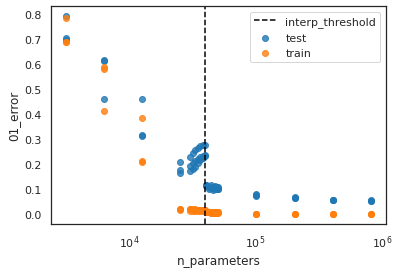

In [13]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df# [(df['hidden_layer_dims'] >= 38) & (df['hidden_layer_dims'] <= 64)]

fig, ax = plt.subplots(1, 1, sharex=True)

sns.regplot(
    data=plot_df, x='n_parameters', y=test_error, lowess=False,
    ax=ax, label='test', fit_reg=False, x_ci=90)
sns.regplot(
    data=plot_df, x='n_parameters', y=train_error, lowess=False,
    ax=ax, label='train', fit_reg=False, x_ci=90)

ax.axvline(10*df['n_train_samples'].iloc[0], ls='--', c='black', label='interp_threshold')
plt.xscale('log')
plt.ylabel(metric)
# plt.yscale('symlog')
plt.legend()
plt.show()

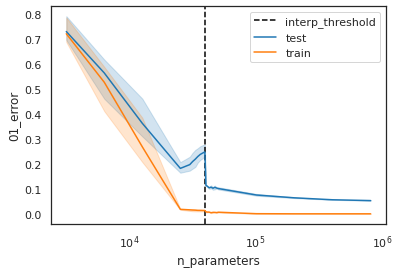

In [14]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df

fig, ax = plt.subplots(1, 1, sharex=True)

ax.axvline(10*df['n_train_samples'].iloc[0], ls='--', c='black', label='interp_threshold')

sns.lineplot(
    data=plot_df, x='n_parameters', y=test_error,
    ax=ax, label='test')
sns.lineplot(
    data=plot_df, x='n_parameters', y=train_error,
    ax=ax, label='train')

plt.xscale('log')
plt.ylabel(metric)
plt.legend()
plt.show()

In [15]:
corr_vars = [
    'generalization_gap', test_error,
    'n_parameters', 'depth', 'width', 'n_epochs',
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', 'entropy',
    'rows_mean_L2',
    'cols_mean_L1', 'cols_mean_L2',
]
# for hidden_layer_dims in df['hidden_layer_dims'].unique():
# print(hidden_layer_dims)
corr_df = df[corr_vars].corr('spearman')
display(corr_df)
# corr_df.to_csv('./results/dn_spearman_corrs.csv')

,generalization_gap,test_01_error,n_parameters,depth,width,n_epochs,IRM_L1,IRM_L2,n_regions,ACTS_L2,IRM_h*,ACTS_h*,entropy,rows_mean_L2,cols_mean_L1,cols_mean_L2
generalization_gap,1.000000,0.432430,-0.346495,NaN,-0.346495,NaN,-0.378995,-0.276327,-0.367893,0.352930,-0.372530,0.177253,-0.357511,-0.246860,-0.675709,-0.829565
test_01_error,0.432430,1.000000,-0.913044,NaN,-0.913044,NaN,-0.956668,-0.788308,-0.945785,0.932261,-0.941287,-0.264359,-0.937779,-0.767008,-0.744794,-0.590976
n_parameters,-0.346495,-0.913044,1.000000,NaN,1.000000,NaN,0.921381,0.746846,0.962816,-0.939964,0.983309,0.280817,0.895930,0.715581,0.665667,0.517132
depth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
width,-0.346495,-0.913044,1.000000,NaN,1.000000,NaN,0.921381,0.746846,0.962816,-0.939964,0.983309,0.280817,0.895930,0.715581,0.665667,0.517132
n_epochs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IRM_L1,-0.378995,-0.956668,0.921381,NaN,0.921381,NaN,1.000000,0.895652,0.976509,-0.973190,0.943773,0.295083,0.994008,0.875301,0.824845,0.653818
IRM_L2,-0.276327,-0.788308,0.746846,NaN,0.746846,NaN,0.895652,1.000000,0.836804,-0.860242,0.765121,0.155378,0.920460,0.991487,0.829119,0.659335
n_regions,-0.367893,-0.945785,0.962816,NaN,0.962816,NaN,0.976509,0.836804,1.000000,-0.977691,0.979792,0.317820,0.959647,0.808128,0.762882,0.601396
ACTS_L2,0.352930,0.932261,-0.939964,NaN,-0.939964,NaN,-0.973190,-0.860242,-0.977691,1.000000,-0.946200,-0.295517,-0.967594,-0.833505,-0.787638,-0.622897


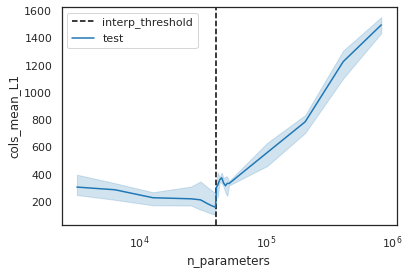

In [16]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df

fig, ax = plt.subplots(1, 1, sharex=True)

ax.axvline(10*df['n_train_samples'].iloc[0], ls='--', c='black', label='interp_threshold')

sns.lineplot(
    data=plot_df, x='n_parameters', y='cols_mean_L1',
    ax=ax, label='test')

plt.xscale('log')
plt.legend()
plt.show()

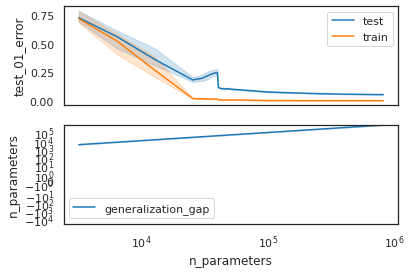

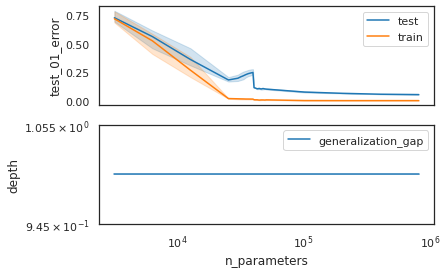

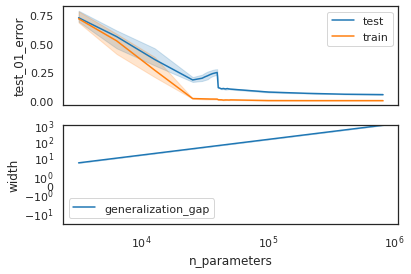

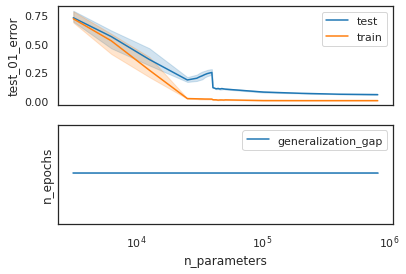

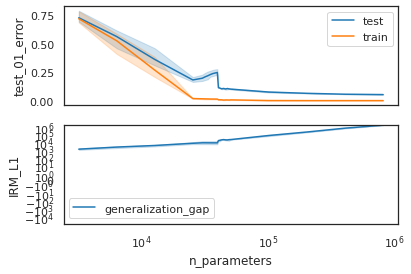

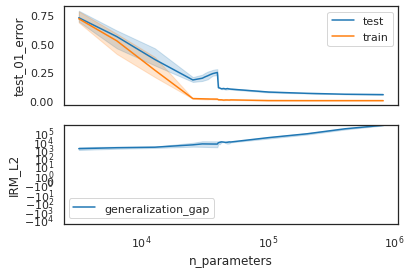

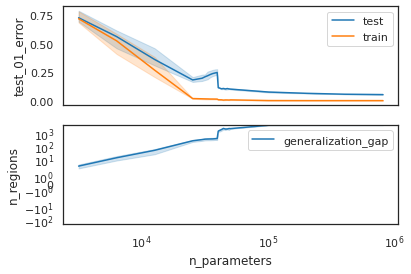

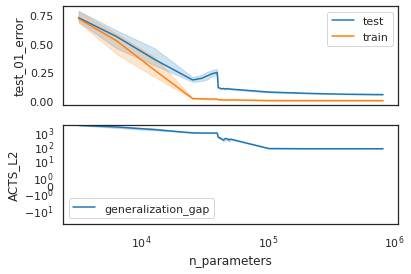

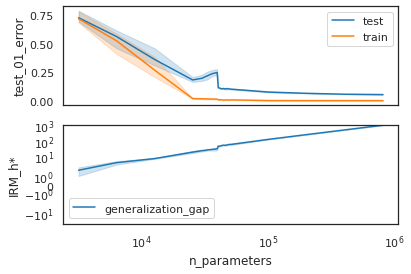

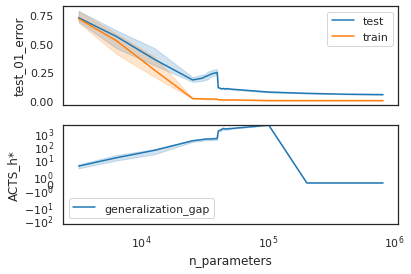

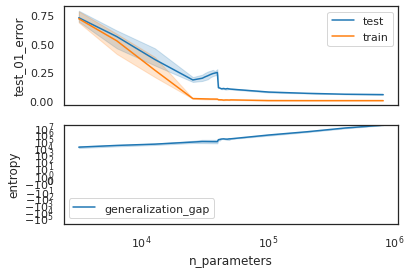

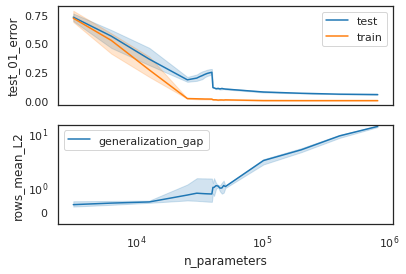

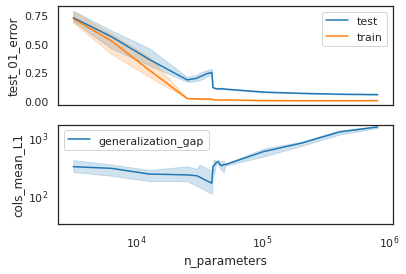

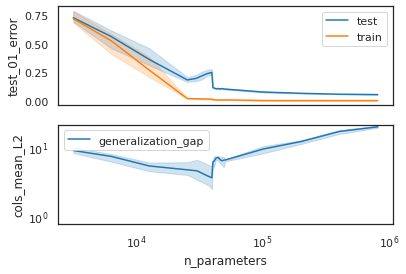

In [18]:
for var in corr_vars[2:]:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    sns.lineplot(
        data=plot_df, x='n_parameters', y=test_error,
        ax=ax1, label='test')
    sns.lineplot(
        data=plot_df, x='n_parameters', y=train_error,
        ax=ax1, label='train')
    sns.lineplot(
        data=plot_df, x='n_parameters', y=var,
        ax=ax2, label='generalization_gap')

    ax1.set_xscale('log')
    plt.yscale('symlog')#, linthresh=1e-3)
    plt.legend()
    plt.show()

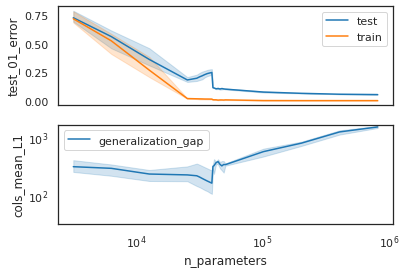

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

var = 'cols_mean_L1'
sns.lineplot(
    data=plot_df, x='n_parameters', y=test_error,
    ax=ax1, label='test')
sns.lineplot(
    data=plot_df, x='n_parameters', y=train_error,
    ax=ax1, label='train')
sns.lineplot(
    data=plot_df, x='n_parameters', y=var,
    ax=ax2, label='generalization_gap')

ax1.set_xscale('log')
plt.yscale('symlog')#, linthresh=1e-3)
plt.legend()
plt.show()

## notepad

Thoughts:
- region complexity should be L1 (a parameter in one region moved to another should be the same overall complexity for equal sized regions)

- size complexity should be L1?

Metric notes:

- metric = sum_{unique regions} (size * region complexity) = sum_{regions} region_complexity = sum of matrix = col_mean_L1 * n_samples

- metric = col_mean_L2 ~ sum_{regions} region_complexity^2 = sum_{unique_regions} size * region_complexity^2

## Forest

In [86]:
#
algo = "forest"
dataset = "mnist"

# Read
df = pd.read_csv(f'./results/{dataset}/{dataset}_{algo}_belkin_results.csv')


# Define headers
metric = "mse"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]

# Average across reps
df = df.groupby(
    ['model', 'n_train_samples', 'max_depth', 'n_estimators'],
    as_index=False,
).mean()

# max_leaves = df.loc[
#     (df['n_estimators'] == 1) & (df['max_depth'] != 'None'),
#     'max_depth'
# ].astype(int).max()
# df['forest_capacity'] = df['']

# df.loc[
#     (df['n_estimators'] > 1) & (df['max_depth'] != 'None'),
#     'max_depth'
# ] = max_leaves

# df['n_max_leaves'] = max_leaves * df['n_estimators']

df.head(5)

,model,n_train_samples,max_depth,n_estimators,rep,n_test_samples,bootstrap,n_jobs,train_01_error,train_mse,...,n_regions,ACTS_L2,IRM_h*,ACTS_h*,entropy,IRM_rows_mean_L2,IRM_cols_mean_L1,IRM_cols_mean_L2,n_total_leaves,generalization_gap
0,forest,10000.0,1,1.0,1.0,10000.0,0.0,-2.0,0.808833,0.926961,...,2.000000,7168.850801,2.000000,2.000000,85314.319954,0.716885,5000.000000,50.000000,2.000000,0.000846
1,forest,10000.0,10,1.0,1.0,10000.0,0.0,-2.0,0.131600,0.234116,...,652.000000,1407.257025,652.000000,652.000000,41840.353369,0.140726,15.341371,0.153414,652.000000,0.155766
2,forest,10000.0,11,1.0,1.0,10000.0,0.0,-2.0,0.080067,0.147150,...,875.666667,1373.475814,875.666667,875.666667,39768.352955,0.137348,11.421201,0.114212,875.666667,0.209063
3,forest,10000.0,12,1.0,1.0,10000.0,0.0,-2.0,0.056233,0.104099,...,1135.666667,1333.145484,1135.666667,1135.666667,38278.888898,0.133315,8.817067,0.088171,1135.666667,0.260765
4,forest,10000.0,13,1.0,1.0,10000.0,0.0,-2.0,0.037600,0.070193,...,1259.333333,1292.823125,1259.333333,1259.333333,36996.174125,0.129282,7.941293,0.079413,1259.333333,0.279272


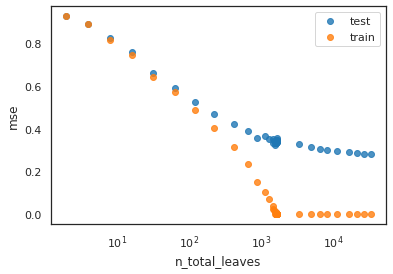

In [87]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df # [df["n_estimators"] > 1]

fig, ax = plt.subplots(1, 1, sharex=True)

sns.regplot(
    data=plot_df, x='n_total_leaves', y=test_error, lowess=False,
    ax=ax, label='test', fit_reg=False, x_ci=90)
sns.regplot(
    data=plot_df, x='n_total_leaves', y=train_error, lowess=False,
    ax=ax, label='train', fit_reg=False, x_ci=90)

# ax.axvline(10*df['n_train_samples'].iloc[0], ls='--', c='black', label='interp_threshold')
plt.xscale('log')
# plt.yscale('symlog')
plt.ylabel(metric)
plt.legend()
plt.show()

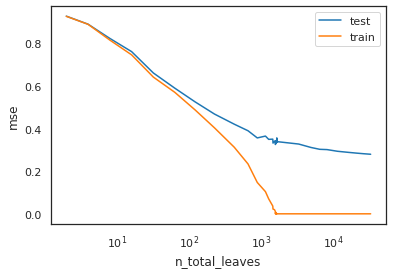

In [88]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df

fig, ax = plt.subplots(1, 1, sharex=True)

sns.lineplot(
    data=df, x='n_total_leaves', y=test_error,
    ax=ax, label='test')
sns.lineplot(
    data=df, x='n_total_leaves', y=train_error,
    ax=ax, label='train')

plt.xscale('log')
plt.ylabel(metric)
plt.legend()
plt.show()

In [89]:
corr_vars = [
    'generalization_gap', test_error,
    'n_total_leaves', 'n_estimators',
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', 'entropy',
    'IRM_rows_mean_L2',
    'IRM_cols_mean_L1', 'IRM_cols_mean_L2',
]
# for hidden_layer_dims in df['hidden_layer_dims'].unique():
# print(hidden_layer_dims)
corr_df = df[corr_vars].corr('spearman')
display(corr_df)
# corr_df.to_csv('./results/dn_spearman_corrs.csv')

,generalization_gap,test_mse,n_total_leaves,n_estimators,IRM_L1,IRM_L2,n_regions,ACTS_L2,IRM_h*,ACTS_h*,entropy,IRM_rows_mean_L2,IRM_cols_mean_L1,IRM_cols_mean_L2
generalization_gap,1.000000,-0.269082,0.514095,-0.226634,-0.226634,-0.802857,0.514095,-0.457755,0.514095,0.514095,-0.815612,-0.828673,-0.740510,-0.740510
test_mse,-0.269082,1.000000,-0.790275,-0.672271,-0.672271,0.008673,-0.790275,0.835408,-0.790275,-0.790275,-0.104082,0.081020,0.589694,0.589694
n_total_leaves,0.514095,-0.790275,1.000000,0.675386,0.675386,-0.109748,1.000000,-0.940075,1.000000,1.000000,-0.080818,-0.182301,-0.903952,-0.903952
n_estimators,-0.226634,-0.672271,0.675386,1.000000,1.000000,0.608285,0.675386,-0.675368,0.675386,0.675386,0.666076,0.544601,-0.339044,-0.339044
IRM_L1,-0.226634,-0.672271,0.675386,1.000000,1.000000,0.608285,0.675386,-0.675368,0.675386,0.675386,0.666076,0.544601,-0.339044,-0.339044
IRM_L2,-0.802857,0.008673,-0.109748,0.608285,0.608285,1.000000,-0.109748,0.169694,-0.109748,-0.109748,0.968265,0.995918,0.426122,0.426122
n_regions,0.514095,-0.790275,1.000000,0.675386,0.675386,-0.109748,1.000000,-0.940075,1.000000,1.000000,-0.080818,-0.182301,-0.903952,-0.903952
ACTS_L2,-0.457755,0.835408,-0.940075,-0.675368,-0.675368,0.169694,-0.940075,1.000000,-0.940075,-0.940075,0.073878,0.242245,0.815510,0.815510
IRM_h*,0.514095,-0.790275,1.000000,0.675386,0.675386,-0.109748,1.000000,-0.940075,1.000000,1.000000,-0.080818,-0.182301,-0.903952,-0.903952
ACTS_h*,0.514095,-0.790275,1.000000,0.675386,0.675386,-0.109748,1.000000,-0.940075,1.000000,1.000000,-0.080818,-0.182301,-0.903952,-0.903952


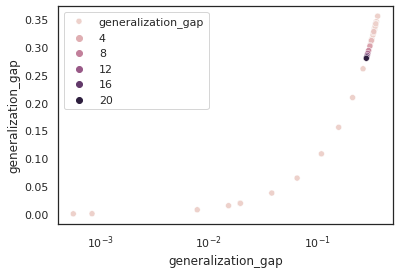

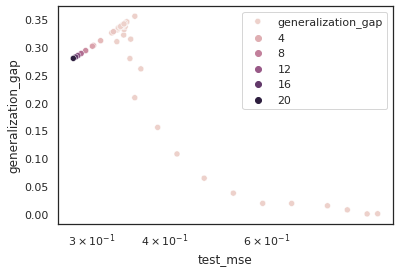

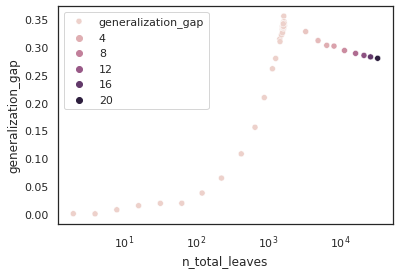

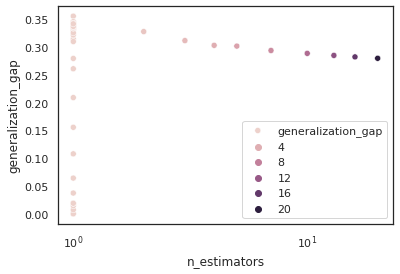

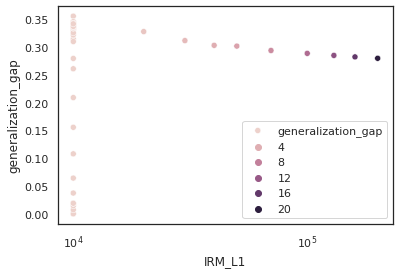

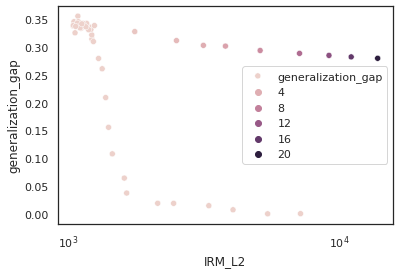

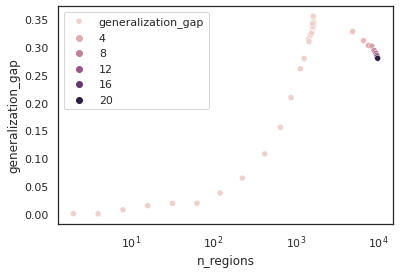

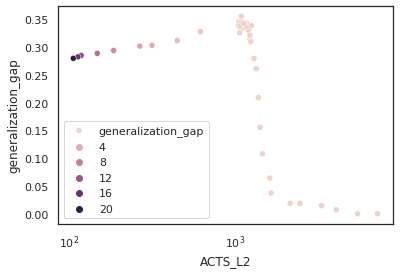

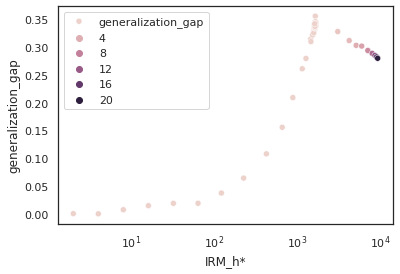

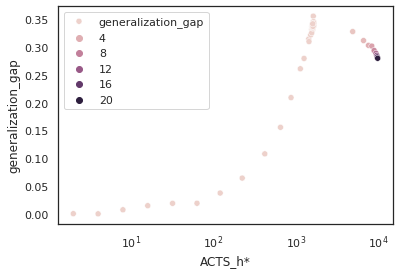

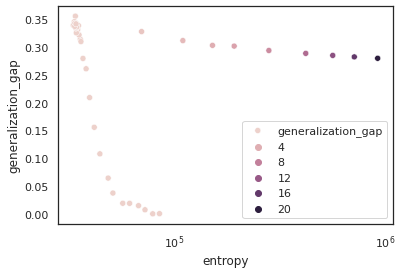

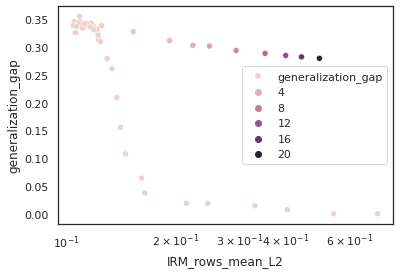

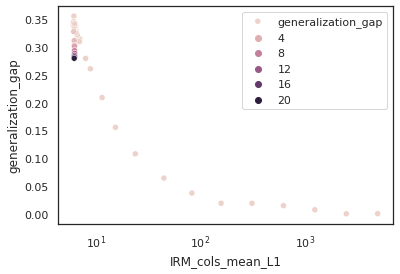

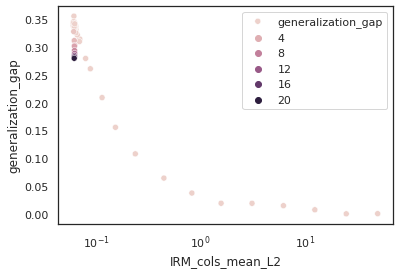

In [96]:
for var in corr_vars:
    fig, ax = plt.subplots(1, 1, sharex=True)

    sns.scatterplot(
        data=plot_df, x=var, y="generalization_gap", hue="n_estimators",
        ax=ax, label='generalization_gap')
    # sns.lineplot(
    #     data=plot_df, x='cols_mean_L1', y=test_error,
    #     ax=ax, label='test')
    # sns.lineplot(
    #     data=plot_df, x='cols_mean_L1', y=train_error,
    #     ax=ax, label='train')

    plt.xscale('log')
    # plt.yscale('symlog', linthresh=1e-3)
    plt.legend()
    plt.show()